# Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing Employment Data

### 1. Importing libraries and data

In [16]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

In [17]:
# Configure API key 

quandl.ApiConfig.api_key = 'RLe8TLRP5cVQbMU6AqF8'

There isn't a dataset that is directly tied to my research question - which is whether COVID mandates impacted the number of COVID cases in the US. I decided to look at the impact of COVID on another sector - so I chose employment. My timeframe is April 2020 (when COVID cases started to be accurately recorded by the CDC) to December 2020 (when the first vaccines were introduced). So, I will look at that time period - 8 months - as well as the 20 months leading up to that period. I had to use 20 months in order to have enough data points for the later graphs. I used this dataset: https://data.nasdaq.com/data/OECD/STLABOUR_USA_LFHUTTTT_ST_Q-united-states-unemployment-monthly-total-all-persons-level-rate-or-quantity-series-quarterly

In [48]:
# Importing the OECD US Unemployment Rate variable.

data = quandl.get('OECD/STLABOUR_USA_LFHUTTTT_ST_Q')

In [49]:
data.head(5)

,Value
Date,
1955-03-31,3511.667
1955-06-30,2915.000
1955-09-30,2512.000
1955-12-31,2473.667
1956-03-31,3084.333


In [50]:
data.shape

(269, 1)

In [51]:
data.columns

Index(['Value'], dtype='object')

In [52]:
type(data)

pandas.core.frame.DataFrame

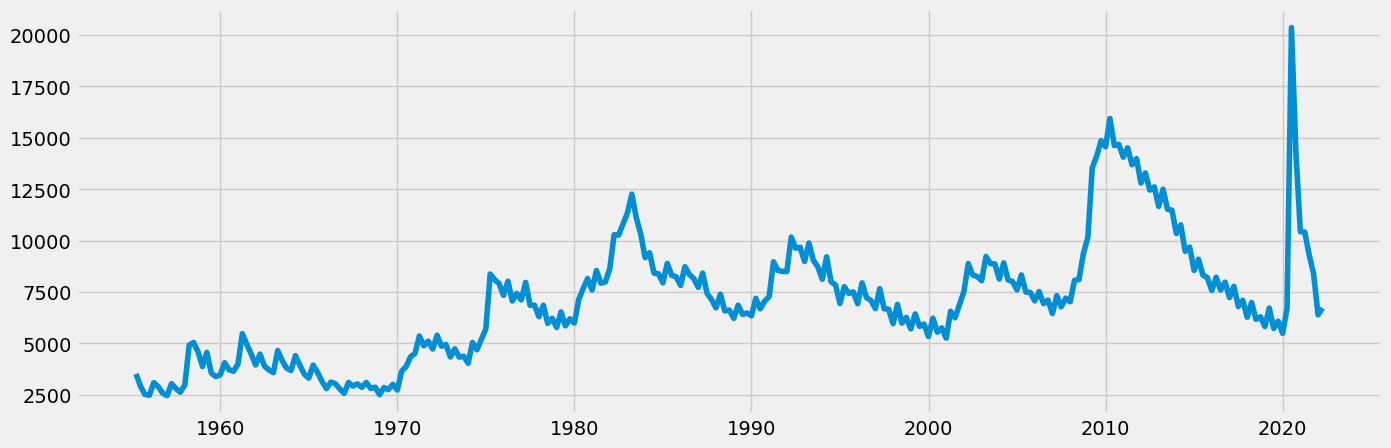

In [53]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

Wow! COVID had an impact on unemployment. It was the largest number of people recorded as unemployed people since 1951 ever recorded. It was relatively short, but it was a huge spike.

### 2. Subsetting, wrangling, and cleaning time-series data

In [54]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [55]:
data_2.head()

,Date,Value
0,1955-03-31,3511.667
1,1955-06-30,2915.000
2,1955-09-30,2512.000
3,1955-12-31,2473.667
4,1956-03-31,3084.333


In [65]:
# My subset will be the pre-vaccine COVID period - April to December 2020 and the 20 months preceeding - see note above
data_sub = data_2.loc[(data_2['Date'] >= '2018-12-01') & (data_2['Date'] < '2020-11-30')]

In [66]:
data_sub.shape

(8, 2)

In [67]:
data_sub.head()

,Date,Value
255,2018-12-31,5816.667
256,2019-03-31,6715.667
257,2019-06-30,5727.333
258,2019-09-30,6074.667
259,2019-12-31,5484.667


In [68]:
# Set the "Date" column index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
2018-12-31,5816.667
2019-03-31,6715.667
2019-06-30,5727.333
2019-09-30,6074.667
2019-12-31,5484.667


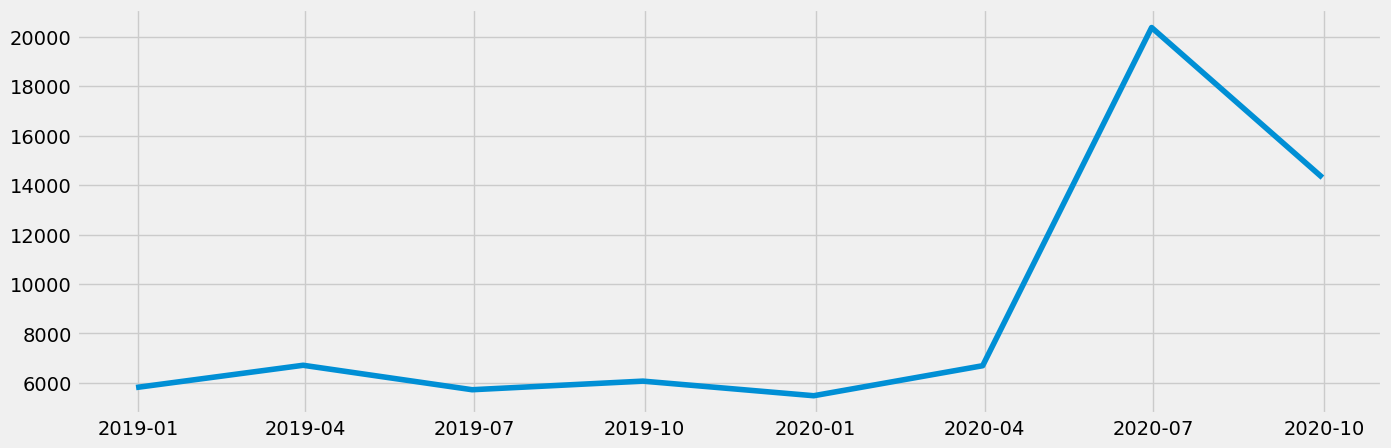

In [69]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

COVID had a clear impact on the unemployment rate! In the 20 months leading up to the pandemic, unemployment was relatively consistent, with a huge spike in April 2020.

In [70]:
# Check for missing values 
data_sub.isnull().sum() 

Value    0
dtype: int64

In [71]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

No dups or nulls.

### 3. Time-series analysis: decomposition

In [72]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [73]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

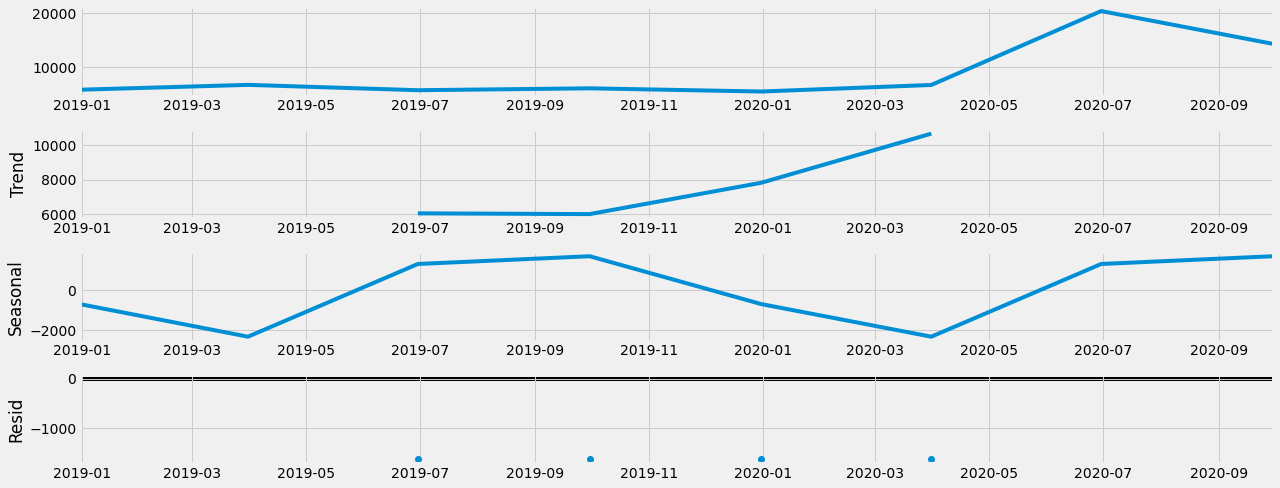

In [75]:
# Plot the separate components
decomposition.plot()
plt.show()

Decomposition illustrates that there is no seasonality to this dataset - which is unsurprising. COVID was an isolated, and unique, time. The first graph in this notebook illustrates that clearly. The trend and data do not differ greatly, suggesting the data does not need to be smoothed. The residual shows there is not much unexplained noise, which makes sense.

### 4. Testing for stationarity

In [76]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.216629
p-value                        0.666402
Number of Lags Used            2.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


Null hypothesis: The early stages of the COVID pandemic did not have an impact on unemployment

Hypothesis: The early stages of the COVID pandemic did have an impact on unemployment

The critical value 5% is -3.9 and test statistic is small at -1.2, so the null can't be rerejected.

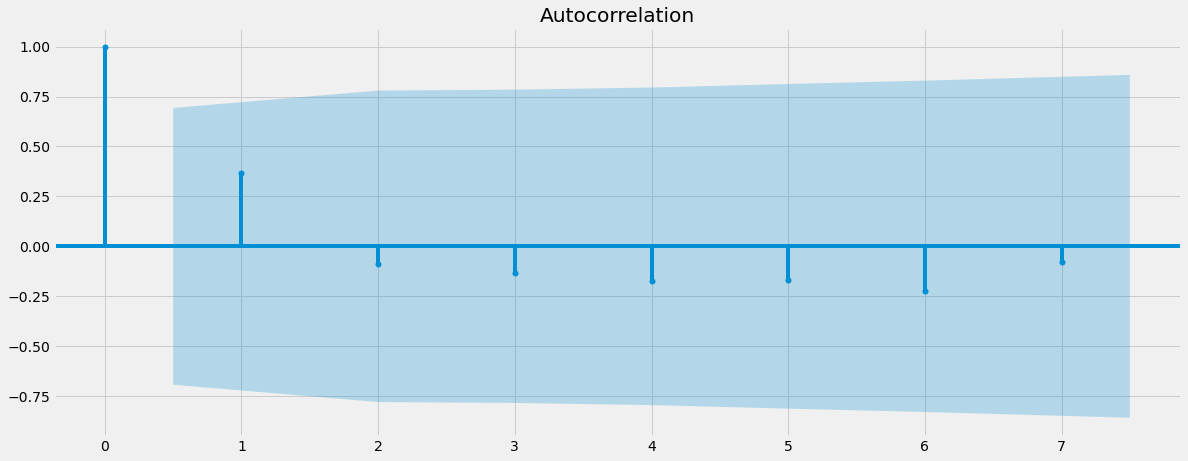

In [77]:
# Plot autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

The Dickey-Fuller test suggests this data is non-stationary. The autocorrelation, however does not support that because the lags are not sigificantly correlated to each other. It is clear this data does not have a trend. This makes sense, as it is illustrating a exception.

### 5. Stationarizing the unemployment data in the US

In [85]:
#Change observations to t-1
data_diff = data_sub - data_sub.shift(1) 

In [86]:
data_diff.dropna(inplace = True)

In [87]:
data_diff.head()

,Value
datetime,
2019-03-31,899.000
2019-06-30,-988.334
2019-09-30,347.334
2019-12-31,-590.000
2020-03-31,1212.666


In [88]:
data_diff.columns

Index(['Value'], dtype='object')

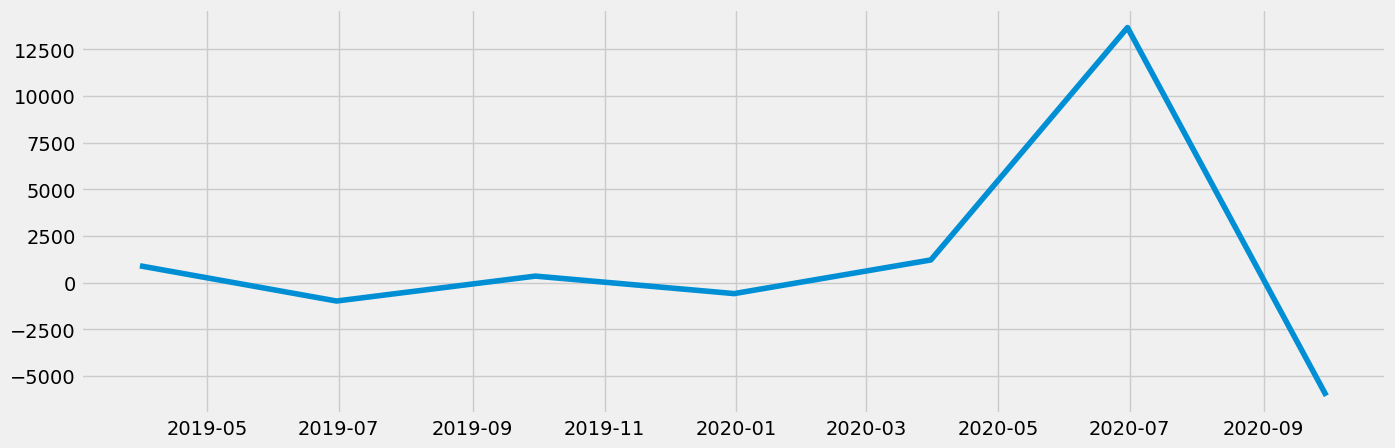

In [89]:
# Impact of differencing on curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [90]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -2.995275
p-value                        0.035338
Number of Lags Used            0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


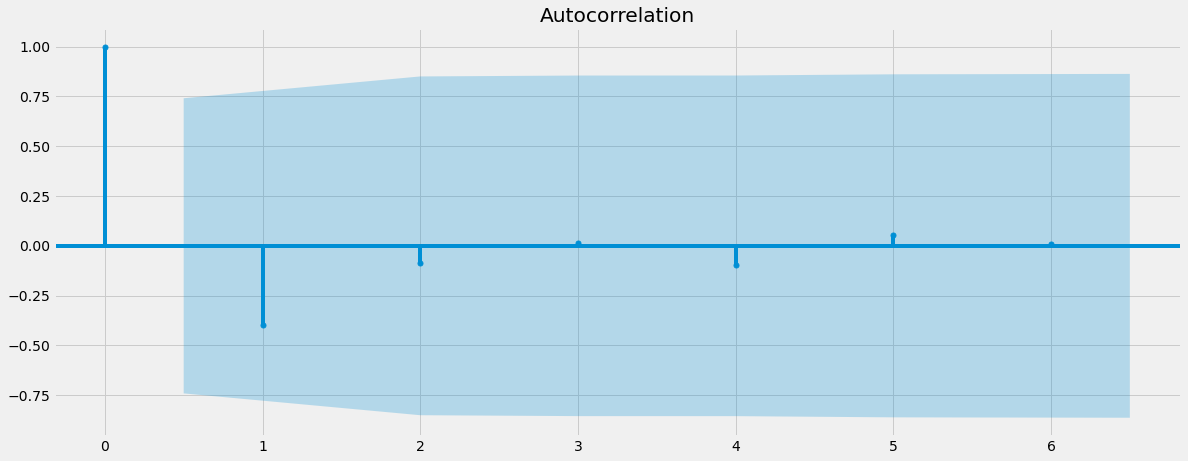

In [91]:
plot_acf(data_diff)
plt.show()

In [92]:
#Change observations to t-2
data_diff_2 = data_sub - data_sub.shift(2) 

In [93]:
data_diff_2.dropna(inplace = True)

In [94]:
data_diff_2.head()

,Value
datetime,
2019-06-30,-89.334
2019-09-30,-641.000
2019-12-31,-242.666
2020-03-31,622.666
2020-06-30,14878.663


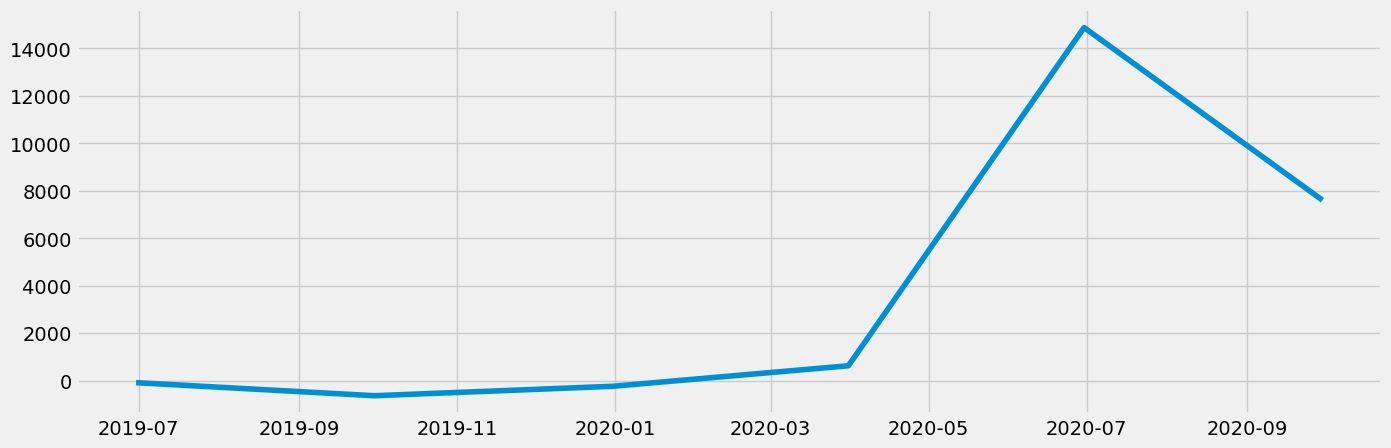

In [95]:
# Impact of differencing on curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [96]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.236234
p-value                        0.657818
Number of Lags Used            0.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


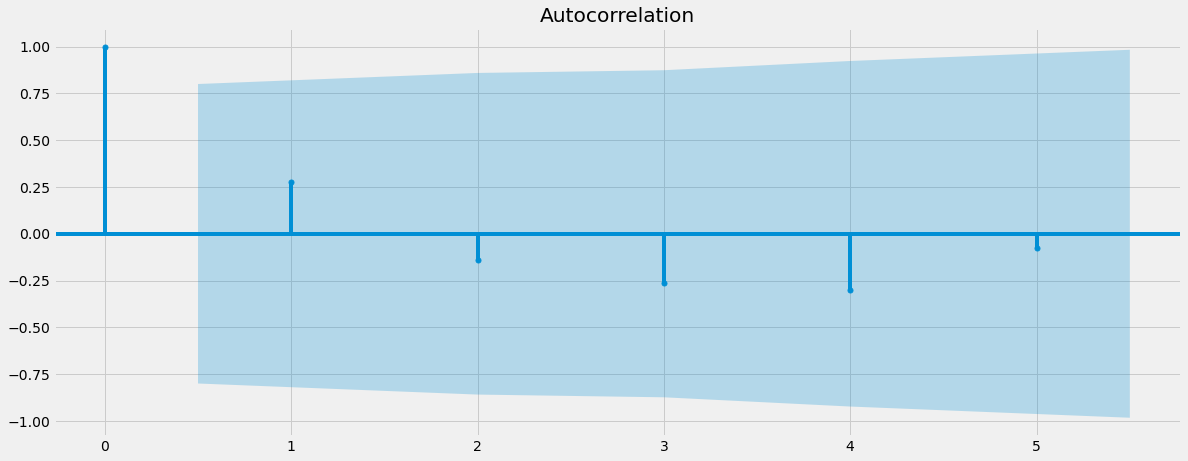

In [97]:
plot_acf(data_diff_2)
plt.show()

Still no trend. Null cannot be rejected.